<a href="https://colab.research.google.com/github/maliozdemir1/dsa210-project-impact-of-climate-on-gastronomic-diversity/blob/main/HypothesisTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd
import numpy as np
import re

FOODS_PATH = "manual_clean_en.csv"
CLIM_PATH  = "iklim_mgm_1991_2020.csv"

def normalize_province(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip().upper()
    tr_map = str.maketrans({
        "İ":"I","I":"I","ı":"I",
        "Ş":"S","Ğ":"G","Ü":"U","Ö":"O","Ç":"C",
        "Â":"A","Ê":"E","Û":"U"
    })
    s = s.translate(tr_map)
    s = re.sub(r"[^A-Z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.replace(" ", "")

# 1) Load
foods = pd.read_csv(FOODS_PATH, encoding="utf-8-sig")
clim  = pd.read_csv(CLIM_PATH, encoding="utf-8-sig")

# 2) Ensure numeric
foods["kcal_100g"] = pd.to_numeric(foods["kcal_100g"], errors="coerce")
clim["temp_annual_mean"] = pd.to_numeric(clim["temp_annual_mean"], errors="coerce")
clim["prec_annual_total"] = pd.to_numeric(clim["prec_annual_total"], errors="coerce")

# 3) Keys for matching
foods["prov_key"] = foods["province"].apply(normalize_province)
clim["prov_key"]  = clim["province"].apply(normalize_province)

print("Foods rows:", len(foods), "| unique provinces:", foods["prov_key"].nunique())
print("Climate rows:", len(clim),  "| unique provinces:", clim["prov_key"].nunique())

# 4) Province-level aggregation
foods_prov = (foods.groupby(["prov_key","province"], dropna=False)
              .agg(n_foods=("food_name","size"),
                   mean_kcal=("kcal_100g","mean"),
                   median_kcal=("kcal_100g","median"),
                   std_kcal=("kcal_100g","std"))
              .reset_index())

# 5) Merge
merged = foods_prov.merge(
    clim[["prov_key","temp_annual_mean","prec_annual_total"]],
    on="prov_key",
    how="inner"
)

print("Merged provinces:", merged.shape[0])
display(merged.head(5))


Foods rows: 1530 | unique provinces: 83
Climate rows: 79 | unique provinces: 79
Merged provinces: 79


,prov_key,province,n_foods,mean_kcal,median_kcal,std_kcal,temp_annual_mean,prec_annual_total
0,ADANA,Adana,20,224.400000,227.5,212.563402,19.458333,680.8
1,ADIYAMAN,Adıyaman,7,216.857143,171.0,207.880117,17.683333,729.5
2,AFYONKARAHISAR,Afyonkarahisar,47,239.808511,241.0,122.455429,11.691667,451.4
3,AGRI,Ağrı,6,283.500000,276.5,61.282134,6.691667,512.9
4,AKSARAY,Aksaray,11,308.000000,277.0,139.529208,12.775000,349.4


From here,


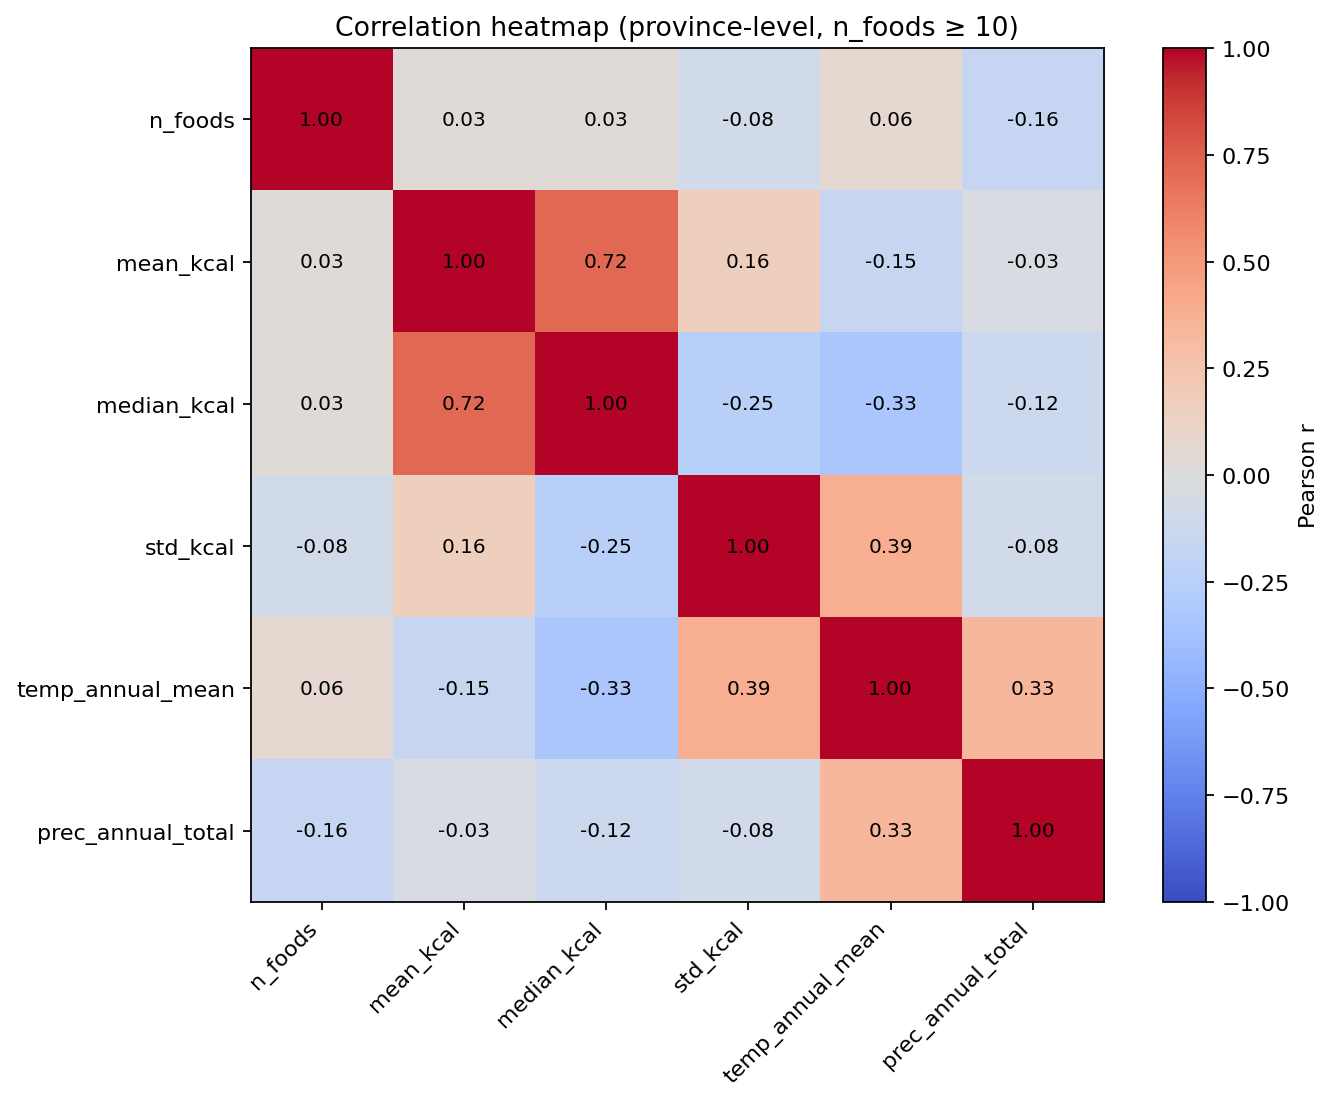

In [20]:
import numpy as np
import matplotlib.pyplot as plt

num_cols = ["n_foods","mean_kcal","median_kcal","std_kcal","temp_annual_mean","prec_annual_total"]

min_n = 10
df_corr = merged[merged["n_foods"] >= min_n][num_cols].copy()

corr = df_corr.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(9,7), dpi=160)
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")

ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha="right")
ax.set_yticklabels(num_cols)

ax.set_title(f"Correlation heatmap (province-level, n_foods ≥ {min_n})")

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center", fontsize=9)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Pearson r")

plt.tight_layout()
plt.show()


In [21]:
import numpy as np

# rebuild foods_prov with more stats
foods_prov = (foods.groupby(["prov_key","province"], dropna=False)
              .agg(n_foods=("food_name","size"),
                   mean_kcal=("kcal_100g","mean"),
                   median_kcal=("kcal_100g","median"),
                   std_kcal=("kcal_100g","std"),
                   min_kcal=("kcal_100g","min"),
                   max_kcal=("kcal_100g","max"),
                   q1_kcal=("kcal_100g", lambda x: x.quantile(0.25)),
                   q3_kcal=("kcal_100g", lambda x: x.quantile(0.75)))
              .reset_index())

foods_prov["iqr_kcal"] = foods_prov["q3_kcal"] - foods_prov["q1_kcal"]
foods_prov["cv_kcal"]  = foods_prov["std_kcal"] / foods_prov["mean_kcal"]

# merge again
merged = foods_prov.merge(
    clim[["prov_key","temp_annual_mean","prec_annual_total"]],
    on="prov_key",
    how="inner"
)

print("Merged provinces:", merged.shape[0])
display(merged.head(3))


Merged provinces: 79


,prov_key,province,n_foods,mean_kcal,median_kcal,std_kcal,min_kcal,max_kcal,q1_kcal,q3_kcal,iqr_kcal,cv_kcal,temp_annual_mean,prec_annual_total
0,ADANA,Adana,20,224.400000,227.5,212.563402,22,886,56.25,296.5,240.25,0.947252,19.458333,680.8
1,ADIYAMAN,Adıyaman,7,216.857143,171.0,207.880117,42,612,48.00,298.5,250.50,0.958604,17.683333,729.5
2,AFYONKARAHISAR,Afyonkarahisar,47,239.808511,241.0,122.455429,42,540,163.00,305.5,142.50,0.510638,11.691667,451.4


In [22]:
from scipy.stats import spearmanr
import pandas as pd

num_cols = ["n_foods","mean_kcal","median_kcal","std_kcal","min_kcal","max_kcal","iqr_kcal","cv_kcal",
            "temp_annual_mean","prec_annual_total"]

df = merged[num_cols].dropna()
rho, _ = spearmanr(df.values)
spearman_corr = pd.DataFrame(rho, index=num_cols, columns=num_cols)

display(spearman_corr.round(2).head())


,n_foods,mean_kcal,median_kcal,std_kcal,min_kcal,max_kcal,iqr_kcal,cv_kcal,temp_annual_mean,prec_annual_total
n_foods,1.00,0.15,0.04,0.10,-0.56,0.55,0.04,0.02,0.22,-0.12
mean_kcal,0.15,1.00,0.75,0.07,0.15,0.46,-0.37,-0.37,-0.06,-0.03
median_kcal,0.04,0.75,1.00,-0.15,0.21,0.11,-0.38,-0.50,-0.16,-0.02
std_kcal,0.10,0.07,-0.15,1.00,-0.50,0.70,0.68,0.86,0.51,0.16
min_kcal,-0.56,0.15,0.21,-0.50,1.00,-0.51,-0.41,-0.53,-0.34,0.00


In [23]:
from scipy.stats import pearsonr, spearmanr

x = merged["temp_annual_mean"]
y = merged["mean_kcal"]

r_p, p_p = pearsonr(x, y)
r_s, p_s = spearmanr(x, y)

print("TEMP vs mean_kcal")
print(f"Pearson r={r_p:.3f}, p={p_p:.4g}")
print(f"Spearman ρ={r_s:.3f}, p={p_s:.4g}")

x2 = merged["prec_annual_total"]
r_p2, p_p2 = pearsonr(x2, y)
r_s2, p_s2 = spearmanr(x2, y)

print("\nPRECIP vs mean_kcal")
print(f"Pearson r={r_p2:.3f}, p={p_p2:.4g}")
print(f"Spearman ρ={r_s2:.3f}, p={p_s2:.4g}")


TEMP vs mean_kcal
Pearson r=-0.041, p=0.7167
Spearman ρ=-0.063, p=0.5782

PRECIP vs mean_kcal
Pearson r=-0.016, p=0.8865
Spearman ρ=-0.028, p=0.8083


In [24]:
from scipy.stats import ttest_ind, mannwhitneyu

# split by median temperature
temp_med = merged["temp_annual_mean"].median()
cold = merged[merged["temp_annual_mean"] < temp_med]["mean_kcal"]
hot  = merged[merged["temp_annual_mean"] >= temp_med]["mean_kcal"]

# t-test (optional)
t, p = ttest_ind(cold, hot, equal_var=False, nan_policy="omit")
print(f"T-test (cold vs hot): t={t:.3f}, p={p:.4g}")

# Mann–Whitney U (recommended)
u, p_u = mannwhitneyu(cold, hot, alternative="two-sided")
print(f"Mann–Whitney U (cold vs hot): U={u:.1f}, p={p_u:.4g}")

print("\nMeans:")
print("Cold mean_kcal:", cold.mean())
print("Hot  mean_kcal:", hot.mean())


T-test (cold vs hot): t=0.347, p=0.7293
Mann–Whitney U (cold vs hot): U=817.0, p=0.7204

Means:
Cold mean_kcal: 239.08858673285997
Hot  mean_kcal: 235.60334079250106


When we compare the hor and cold climate regions, with t -test and Mann-Whitney U test, there is not a significant difference between these regions caloie levels.

In [25]:
from scipy.stats import chi2_contingency

df = foods.merge(clim[["prov_key","temp_annual_mean","prec_annual_total"]], on="prov_key", how="inner")

# create bins
df["temp_bin"] = pd.qcut(df["temp_annual_mean"], q=3, labels=["Cold","Mild","Hot"])
df["prec_bin"] = pd.qcut(df["prec_annual_total"], q=3, labels=["Dry","Normal","Wet"])
df["climate_bin"] = df["temp_bin"].astype(str) + "_" + df["prec_bin"].astype(str)

# keep top categories to avoid sparsity
K=10
top = df["product_group_en"].value_counts().head(K).index
df = df[df["product_group_en"].isin(top)].copy()

ct = pd.crosstab(df["climate_bin"], df["product_group_en"])
chi2, p, dof, exp = chi2_contingency(ct)

print("Chi-square independence (climate_bin x product_group)")
print(f"chi2={chi2:.2f}, dof={dof}, p={p:.4g}")


Chi-square independence (climate_bin x product_group)
chi2=246.10, dof=72, p=6.957e-21


The relationship between climate bins and product groups was examined using a Chi-square test, and the results were found to be statistically significant. However, the effect size, measured by Cramér’s V as $0.146$, indicates a weak relation.

In [26]:
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

# merged must exist (province-level merged dataframe)
# required cols: temp_annual_mean, prec_annual_total, mean_kcal
if "merged" not in globals():
    raise RuntimeError("merged not found. Run the province-level merge cell first.")

x = merged["temp_annual_mean"].astype(float)
y = merged["mean_kcal"].astype(float)

# drop missing
mask = x.notna() & y.notna()
r, p_value = pearsonr(x[mask], y[mask])

print("Test 1 — Pearson correlation (TEMP vs mean_kcal)")
print("Pearson's correlation (r):", r)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print(f"Because p < {alpha}, we reject H0: there is a statistically significant linear relationship.")
else:
    print(f"Because p >= {alpha}, we fail to reject H0: no statistically significant linear relationship was found.")


Test 1 — Pearson correlation (TEMP vs mean_kcal)
Pearson's correlation (r): -0.04146559783609347
P-value: 0.7167274386884394
Because p >= 0.05, we fail to reject H0: no statistically significant linear relationship was found.


In [27]:
from scipy.stats import spearmanr

x = merged["temp_annual_mean"].astype(float)
y = merged["mean_kcal"].astype(float)

mask = x.notna() & y.notna()
rho, p_value = spearmanr(x[mask], y[mask])

print("\nTest 2 — Spearman rank correlation (TEMP vs mean_kcal)")
print("Spearman's rho:", rho)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print(f"Because p < {alpha}, we reject H0: a statistically significant monotonic relationship exists.")
else:
    print(f"Because p >= {alpha}, we fail to reject H0: no statistically significant monotonic relationship was found.")



Test 2 — Spearman rank correlation (TEMP vs mean_kcal)
Spearman's rho: -0.06349921189979732
P-value: 0.5782389485021526
Because p >= 0.05, we fail to reject H0: no statistically significant monotonic relationship was found.


In [28]:
from scipy.stats import pearsonr, spearmanr

x = merged["prec_annual_total"].astype(float)
y = merged["mean_kcal"].astype(float)

mask = x.notna() & y.notna()

r, p1 = pearsonr(x[mask], y[mask])
rho, p2 = spearmanr(x[mask], y[mask])

print("\nTest 3 — Climate vs mean_kcal (PRECIP vs mean_kcal)")
print("Pearson r:", r, "| p-value:", p1)
print("Spearman rho:", rho, "| p-value:", p2)

alpha = 0.05
print("\nDecision (alpha=0.05):")
print("Pearson:", "Reject H0" if p1 < alpha else "Fail to reject H0")
print("Spearman:", "Reject H0" if p2 < alpha else "Fail to reject H0")



Test 3 — Climate vs mean_kcal (PRECIP vs mean_kcal)
Pearson r: -0.01631914919571621 | p-value: 0.8864913388293886
Spearman rho: -0.0277265562721558 | p-value: 0.8083481369363507

Decision (alpha=0.05):
Pearson: Fail to reject H0
Spearman: Fail to reject H0


In [29]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

# foods_ml must exist (food-level merged)
if "foods_ml" not in globals():
    raise RuntimeError("foods_ml not found. Use food-level merge (foods + climate) first.")

df = foods_ml.dropna(subset=["product_group_en","temp_annual_mean","prec_annual_total"]).copy()

# climate bins
df["temp_bin"] = pd.qcut(df["temp_annual_mean"], q=3, labels=["Cold","Mild","Hot"])
df["prec_bin"] = pd.qcut(df["prec_annual_total"], q=3, labels=["Dry","Normal","Wet"])
df["climate_bin"] = df["temp_bin"].astype(str) + "_" + df["prec_bin"].astype(str)

# keep top K categories to avoid tiny counts
K = 10
top_types = df["product_group_en"].value_counts().head(K).index
df = df[df["product_group_en"].isin(top_types)].copy()

cont_table = pd.crosstab(df["climate_bin"], df["product_group_en"])

chi2, p_value, dof, expected = chi2_contingency(cont_table)

# Effect size: Cramér's V
n = cont_table.to_numpy().sum()
r, c = cont_table.shape
cramers_v = np.sqrt((chi2 / n) / (min(r-1, c-1)))

print("\nTest 4 — Chi-square independence (climate_bin x food_type)")
print("chi2:", chi2)
print("dof:", dof)
print("p-value:", p_value)
print("Cramér's V:", cramers_v)

alpha = 0.05
if p_value < alpha:
    print(f"Because p < {alpha}, we reject H0: food type distribution depends on climate conditions.")
else:
    print(f"Because p >= {alpha}, we fail to reject H0: no significant dependence was found.")



Test 4 — Chi-square independence (climate_bin x food_type)
chi2: 246.09807422189314
dof: 72
p-value: 6.957340941824371e-21
Cramér's V: 0.1459066850621948
Because p < 0.05, we reject H0: food type distribution depends on climate conditions.


In [30]:
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

df = foods_ml.dropna(subset=["product_group_en","temp_annual_mean","prec_annual_total"]).copy()

# Climate bins
df["temp_bin"] = pd.qcut(df["temp_annual_mean"], q=3, labels=["Cold","Mild","Hot"])
df["prec_bin"] = pd.qcut(df["prec_annual_total"], q=3, labels=["Dry","Normal","Wet"])
df["climate_bin"] = df["temp_bin"].astype(str) + "_" + df["prec_bin"].astype(str)

# Keep top-K food groups (avoid sparse cells)
K = 10
top_types = df["product_group_en"].value_counts().head(K).index
df = df[df["product_group_en"].isin(top_types)].copy()

ct = pd.crosstab(df["climate_bin"], df["product_group_en"])
display(ct)

chi2, p_value, dof, expected = chi2_contingency(ct)

# Effect size: Cramér's V
n = ct.to_numpy().sum()
r, c = ct.shape
cramers_v = np.sqrt((chi2 / n) / (min(r-1, c-1)))

print("\nTest — Chi-square independence (climate_bin x food_type)")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p-value = {p_value:.4g}")
print(f"Cramér's V = {cramers_v:.3f}")

alpha = 0.05
if p_value < alpha:
    print(f"Because p < {alpha}, we reject H0: food type distribution depends on climate.")
else:
    print(f"Because p >= {alpha}, we fail to reject H0: no significant dependence detected.")


product_group_en,"Bakery, pastry & desserts",Cheese,Chocolate & confectionery,"Fruits, vegetables & mushrooms",Honey,Meals & soups,Meat products,Other products,"Seasonings, sauces & salt",Unknown
climate_bin,,,,,,,,,,
Cold_Dry,103,10,5,56,3,133,11,6,5,1
Cold_Normal,36,7,5,29,6,32,5,7,1,0
Cold_Wet,2,2,0,4,2,16,0,1,0,0
Hot_Dry,10,1,0,7,0,26,0,0,0,1
Hot_Normal,33,2,4,38,3,107,1,9,7,3
Hot_Wet,47,6,6,87,2,57,2,2,3,12
Mild_Dry,38,1,10,38,1,38,3,3,5,0
Mild_Normal,30,9,2,35,2,26,3,4,2,8
Mild_Wet,60,4,7,68,14,55,5,5,3,2



Test — Chi-square independence (climate_bin x food_type)
chi2 = 246.10, dof = 72, p-value = 6.957e-21
Cramér's V = 0.146
Because p < 0.05, we reject H0: food type distribution depends on climate.


With the Cramér's Value, we consider the relation between calorie and climate as weak.